In [1]:
from os.path import join, exists
from os import makedirs
from glob import glob

import numpy as np
import pandas as pd

import pickle

from tqdm import tqdm

import json

from PIL import Image, ImageFilter

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter

from nilearn import image, plotting, masking

from joblib import Memory

In [2]:
from DRN import fmri

In [3]:
DRN = fmri()

---

In [4]:
# from core.env import mlagent
# from torchvision import transforms

# convert_tensor = transforms.ToTensor()

In [5]:
import torch

# device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = 'cpu'
device

'cpu'

---

In [6]:
subj = 'DRN04'
list_run = [ss.split('/')[-1] for ss in sorted(glob(join(DRN.dir_behav,subj,'Run?')))]

---

In [7]:
scaler = StandardScaler()

---

### behavioral data

In [8]:
# dict_png, dict_onsettime, _, dict_episode, _ = DRN.get_data_behav(subj, list_run)

In [9]:
# nrows = len(list_run)
# fig, axs = plt.subplots(nrows=nrows, figsize=(50,nrows))

# for ii, (run, x) in enumerate(dict_onsettime.items()):
#     ax = axs[ii]
    
#     ## frames
#     y = np.ones(len(x))
#     ax.scatter(x,y,s=10,linewidths=0.1)
#     ax.set_xlim(-10,710)
#     ax.xaxis.set_major_locator(MultipleLocator(60))
#     ax.xaxis.set_major_formatter('{x:.0f}')
#     ax.xaxis.set_minor_locator(MultipleLocator(10))
    
#     idx_gap = np.where(np.diff(x)>0.4)[0]
#     for idx in idx_gap:
#         ax.vlines(x=x[idx], ymin=0, ymax=3, color='gray', linestyle='--')
#         ax.text(
#             x[idx], 0, '%.1f'%x[idx],
#             va='top', ha='center',
#             color='gray'
#         )
#         ax.vlines(x=x[idx+1], ymin=0, ymax=3, color='gray', linestyle='--')
#         ax.text(
#             x[idx+1], 3, '%.1f'%x[idx+1],
#             va='bottom', ha='center',
#             color='gray'
#         )

#     ## episode
#     idx_end = np.where(np.diff(dict_episode[run]))
#     for idx in idx_end:
#         ax.vlines(x=x[idx], ymin=0, ymax=3, color='red', linestyle=':')

#     ## fMRI
#     ax.scatter(np.arange(0,700,0.5),2*np.ones(DRN.TPs),s=10,linewidths=0.1)
#     ax.set_ylim(0,3)
    
#     ax.set_title(run, loc='left')

# fig.tight_layout()

---

In [10]:
# run = 'Run1'
# idx_input, idx_epi = DRN.get_idx_input(subj, list_run, run, shift=0)
# for a, b in zip(idx_input.values(), idx_epi.values()):
#     print(a.shape, b.shape)

---

In [11]:
# def plot_episode(subj, list_run, run, shift):
    
#     _, dict_onsettime, _, _, _ = DRN.get_data_behav(subj, list_run)
#     idx_input, idx_epi = DRN.get_idx_input(subj, list_run, run, shift)

#     fig, ax = plt.subplots(nrows=1, figsize=(50,2))

#     ax.vlines(x=6, ymin=0, ymax=3, color='black', linestyle='--')
#     ax.text(
#         6, 0, '%.1f'%6,
#         va='top', ha='center',
#         color='gray'
#     )
#     for epi, idx2Dset in idx_input.items():
#         list_idx = idx2Dset.reshape(-1)

#         ## frames
#         x = dict_onsettime[run][list_idx]
#         y = np.ones(len(x))
#         ax.scatter(x,y,s=10,linewidths=0.1)

#         ax.vlines(x=x[-1], ymin=0, ymax=1, color='gray', linestyle='--')
#         ax.text(
#             x[-1], 0, '%.1f'%x[-1],
#             va='top', ha='center',
#             color='gray'
#         )

#         ## fMRI
#         x = np.arange(6,700+shift,0.5)[idx_epi[epi]]
#         y = np.ones(len(x))*2
#         ax.scatter(x,y,s=10,linewidths=0.1)

#         ax.vlines(x=x[-1], ymin=2, ymax=3, color='gray', linestyle='--')
#         ax.text(
#             x[-1], 3, '%.1f'%x[-1],
#             va='bottom', ha='center',
#             color='gray'
#         )

#     ax.set_xlim(0,710)
#     ax.xaxis.set_major_locator(MultipleLocator(60))
#     ax.xaxis.set_major_formatter('{x:.0f}')
#     ax.xaxis.set_minor_locator(MultipleLocator(10))
#     ax.set_ylim(0,3)
#     ax.set_yticklabels([0,'Frames','BOLD',3])

#     ax.set_title('%s (%.1fs shifted)'%(run,shift), loc='left')

#     fig.tight_layout()

In [12]:
# run = 'Run3'
# for shift in [0, 2, 4, 6]:
#     plot_episode(subj,list_run,run,shift)

---

# Encoding model

#### Network

In [13]:
network = DRN.network
network

ContinuousPolicyValue(
  (head): CNN(
    (conv1): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (l): Linear(in_features=3840, out_features=512, bias=True)
  (mu): Linear(in_features=512, out_features=3, bias=True)
  (log_std): Linear(in_features=512, out_features=3, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=True)
)

---

#### Forward

In [14]:
# dir_cache = join(DRN.dir_cache,'forward')
# makedirs(dir_cache, exist_ok=True)
# memory = Memory(dir_cache, verbose=0)

In [15]:
# @memory.cache
# def do_forward(subj, list_run, run, shift=0):
#     input_, output_ = DRN.do_forward(subj=subj, list_run=list_run, run=run, shift=shift)
    
#     return input_, output_

In [16]:
# for run in list_run:
#     input_, output_ = do_forward(subj, list_run, run=run, shift=5)

---

#### Make a pipeline

In [17]:
n_components = 100
pipeline_pca = Pipeline(
    [
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ]
)
pipeline_pca

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=100))])

---

#### Make matrix X

In [18]:
dir_cache = join(DRN.dir_cache,'X')
makedirs(dir_cache, exist_ok=True)
memory = Memory(dir_cache, verbose=0)

In [19]:
@memory.cache
def myfunc_X(subj, list_run, run, shift=0):
    ## design matrix X를 구성할 PC 열벡터들
    X = {}
    ## ======================== All indices ======================== ##
    _, idx_epi = DRN.get_idx_input(subj=subj, list_run=list_run, run=run, shift=shift)
    row = np.concatenate(list(idx_epi.values()))
    ## ======================== forward ======================== ##
    _, output_ = DRN.do_forward(subj=subj, list_run=list_run, run=run, shift=shift)
    (mu, std, v), (conv1, conv2, conv3) = output_
    ## ========================== PCA ========================== ##
    for jj, layer in enumerate([conv1, conv2, conv3]):
        lname = 'conv%1d'%(jj+1)
        key = (run, lname, shift)

        nsamples = layer.shape[0]
        assert len(row) == nsamples
        nfeatures = np.prod(layer.shape[1:])

        PCs = pipeline_pca.fit_transform(layer.reshape(nsamples,nfeatures))
        EV = np.cumsum(pipeline_pca['pca'].explained_variance_ratio_)
        X[(*key, 'Explained_Variance')] = EV

        ## 위 index들 외의 index들은 분석 불가능하므로, feature들을 0으로 둔다
        tmp = np.zeros((DRN.TPs, n_components))

        ## 분석 가능한 index에 순차적으로 PC들을 대입하여 X를 완성시킨다
        tmp[row] = PCs
        X[(*key, 'X')] = tmp
            
    return X

In [20]:
X = {}
for run in list_run:
    for shift in [3, 4, 5, 6, 7, 8]:
        tmp = myfunc_X(subj, list_run=list_run, run=run, shift=shift)
        for key, value in tmp.items():
            X[key] = value

In [21]:
tmp = []
for key in X.keys():
    tmp.append(key[2])
list_shift = np.unique(tmp)
list_shift

array([3, 4, 5, 6, 7, 8])

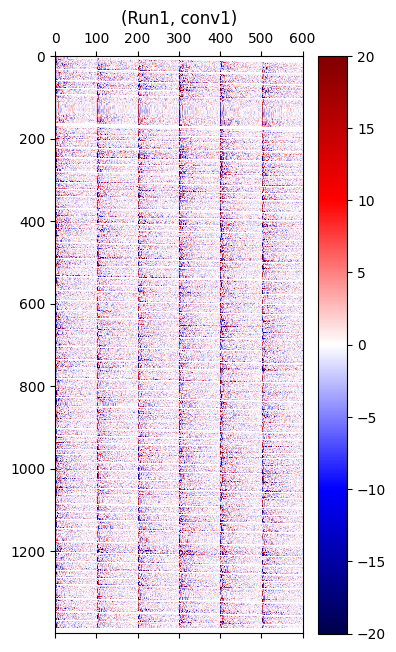

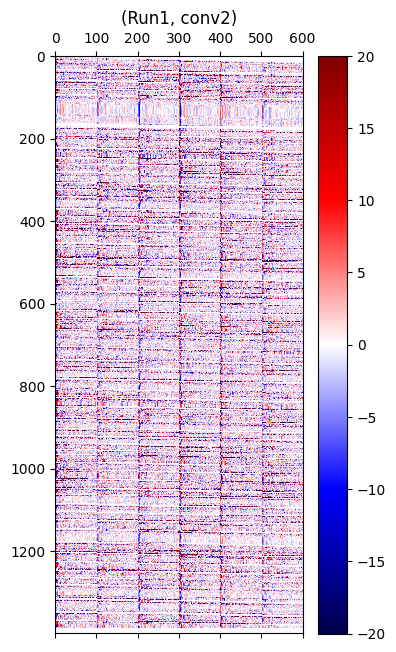

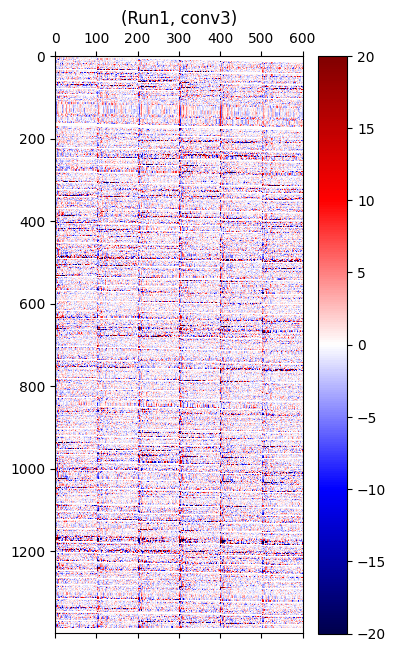

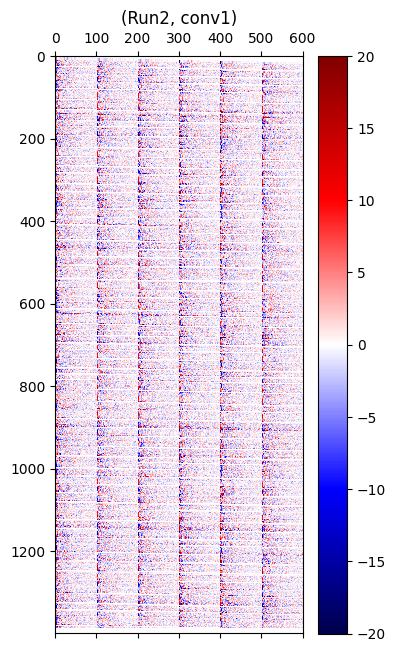

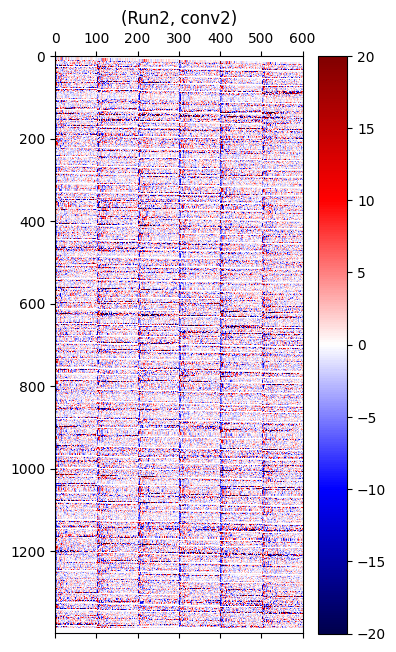

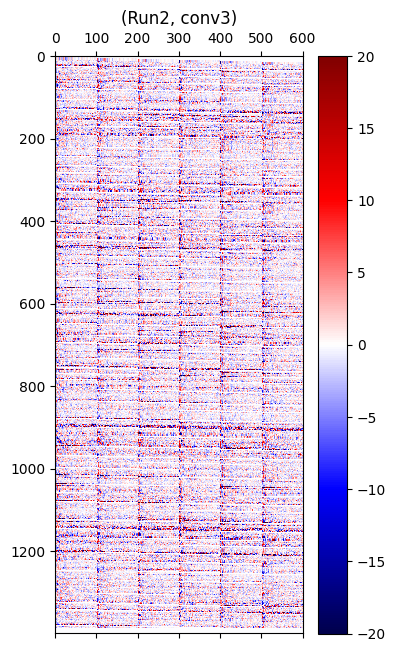

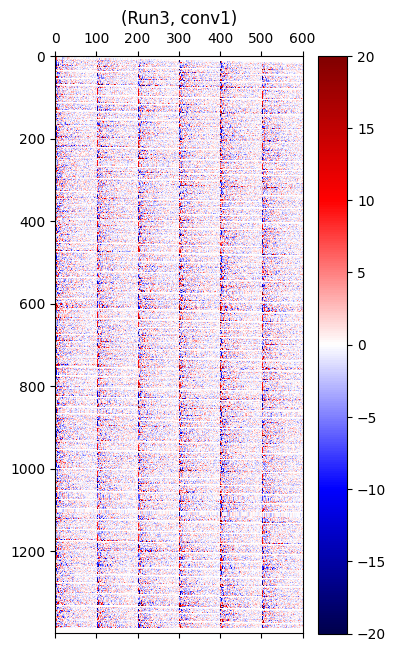

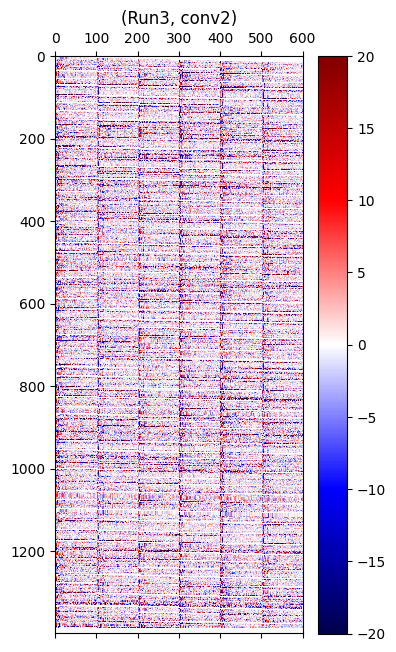

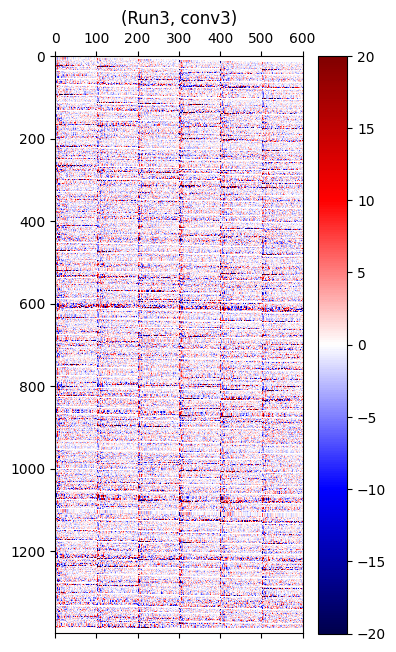

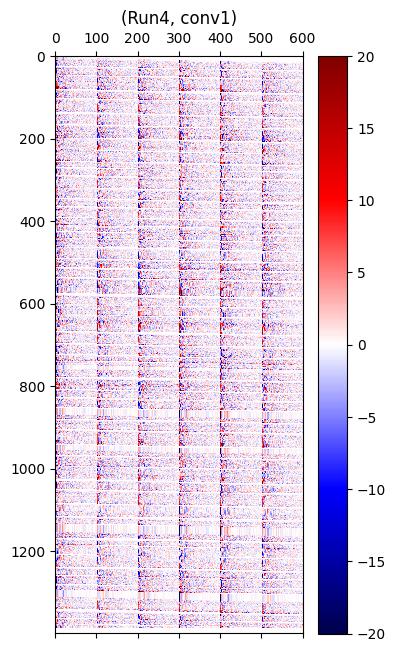

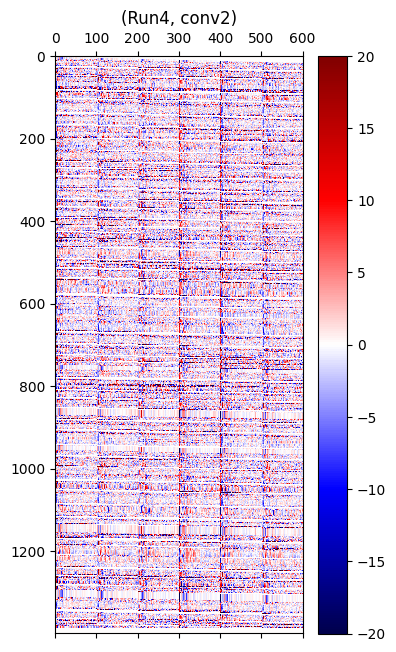

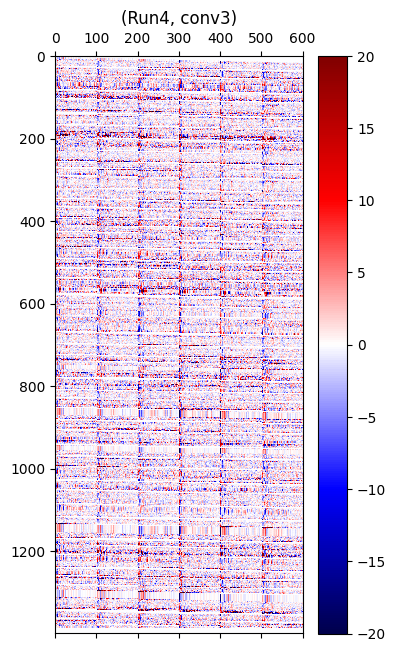

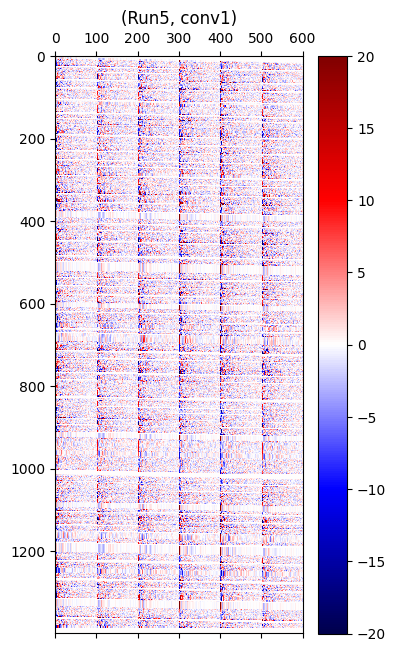

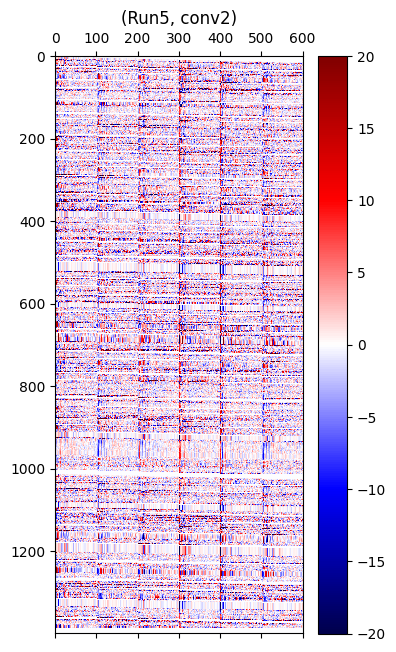

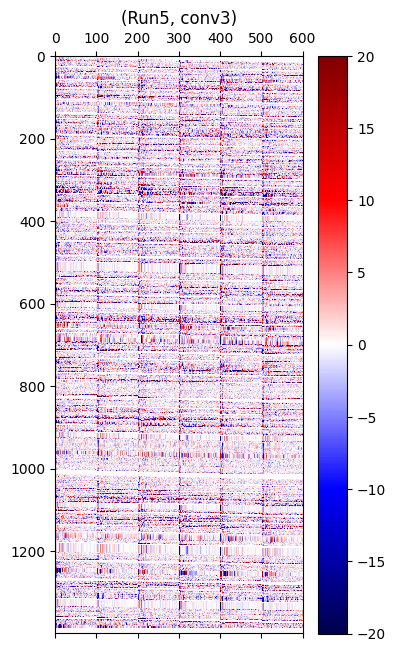

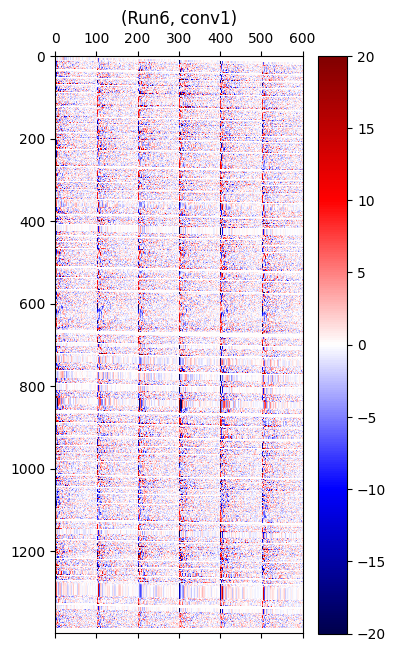

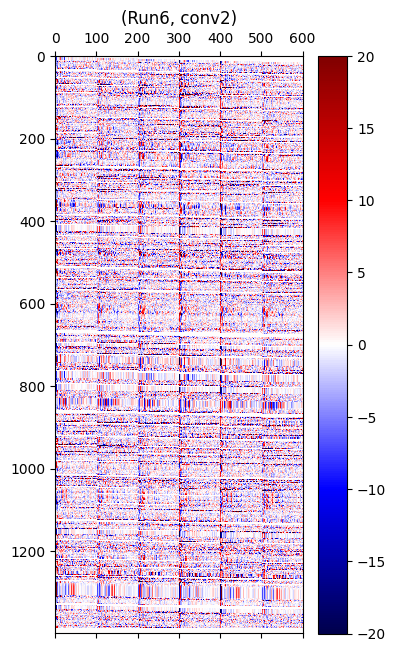

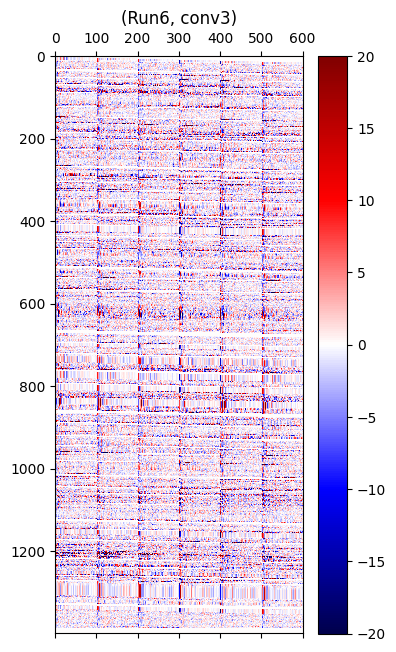

In [22]:
dict_X = {}
for run in list_run:
    for layer in ['conv%1d'%(ii+1) for ii in range(3)]:
        ## vector |1>
        tmp = np.ones((DRN.TPs, 1))
        for ii, shift in enumerate(list_shift):
            ## X' = [|1> X_(n) X_(n+1) X_(n+2) ...]
            tmp = np.concatenate(
                [tmp, X[(run,layer,shift,'X')]],
                axis=1
            )
        dict_X[(run,layer)] = tmp
        plt.matshow(
            dict_X[(run,layer)],
            cmap=cm.seismic, vmin=-20, vmax=20
        )
        plt.title('(%s, %s)'%(run,layer))
        plt.colorbar(shrink=0.8, aspect=20)

In [23]:
Xmat = {}
for layer in ['conv%1d'%(ii+1) for ii in range(3)]:
    print(layer)
    for ii, run in enumerate(list_run):
        if ii==0:
            tmp = dict_X[(run,layer)]
        else:
            tmp = np.concatenate(
                [tmp, dict_X[(run,layer)]],
                axis = 0
            )
    Xmat[layer] = tmp
    print(tmp.shape)

del dict_X, tmp

conv1
(8400, 601)
conv2
(8400, 601)
conv3
(8400, 601)


---

### fMRI data

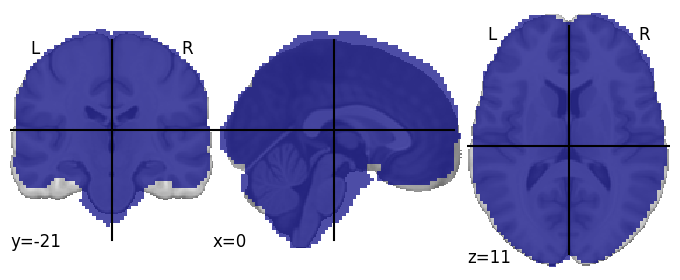

In [24]:
img_mask = glob(join(DRN.dir_mask,'mask.group.n*.frac=0.7.nii'))[-1]
plotting.plot_roi(img_mask)

In [25]:
dir_cache = join(DRN.dir_cache,'apply_mask')
makedirs(dir_cache, exist_ok=True)
memory = Memory(dir_cache, verbose=0)

In [26]:
@memory.cache
def myfunc_apply_mask(subj):
    Y = masking.apply_mask(
        imgs = join(DRN.dir_fmri,'preproc_data',subj,'errts.%s.tproject.nii'%subj),
        mask_img = img_mask
    )
    return Y

In [27]:
Y = myfunc_apply_mask(subj)
print(Y.shape)
(_, nvoxels) = Y.shape

(8400, 118806)


In [28]:
## reshape
Y = Y.reshape(len(list_run),DRN.TPs,nvoxels)

## normalization performed for each RUN
for ii, run in enumerate(list_run):
    if ii==0:
        tmp = scaler.fit_transform(Y[ii])
    else:
        tmp = np.concatenate(
            [tmp, scaler.fit_transform(Y[ii])],
            axis=0
        )
Y = tmp
Y = Y.reshape(len(list_run), DRN.TPs, nvoxels)
Y.shape

(6, 1400, 118806)

In [29]:
# plt.matshow(Y[0], cmap=cm.seismic)
# plt.colorbar(shrink=0.8, aspect=20)

Save the result as .nii

In [32]:
dir_work = join(DRN.dir_fmri,'encoding_model',subj)
makedirs(dir_work, exist_ok=True)

In [33]:
for rr, run in enumerate(tqdm(list_run)):
    fname = join(dir_work,'Y.r%02d.nii'%(rr+1))
    if not exists(fname):
        img = masking.unmask(
            X = Y[rr],
            mask_img = img_mask
        )
        img.to_filename(fname)

100%|██████████| 6/6 [00:21<00:00,  3.56s/it]


In [34]:
for layer, x in Xmat.items():
    np.savetxt(
        fname = join(DRN.dir_fmri,'encoding_model',subj,'Xmat.%s.1D'%layer),
        X = Xmat[layer],
        fmt = '%.5e',
        delimiter = ' ',
        header='# list_shift=%s\n# The number of PC=%d'%(list_shift,n_components)
    )

---

#### Ridge Regression

In [35]:
from himalaya.ridge import RidgeCV

clf = RidgeCV(alphas=np.logspace(start=2, stop=12, num=11))
kf = KFold(n_splits=len(list_run), random_state=None, shuffle=False)

In [36]:
from himalaya.backend import set_backend

# backend = set_backend('torch_cuda', on_error='warn')
backend = set_backend('cpu', on_error='warn')
print(backend)

<module 'himalaya.backend.numpy' from '/home/sungbeenpark/anaconda3/envs/DRN/lib/python3.9/site-packages/himalaya/backend/numpy.py'>


/home/sungbeenpark/anaconda3/envs/DRN/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cpu failed: Unknown backend='cpu'.Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [37]:
dir_cache = join(DRN.dir_cache,'Y_pred')
makedirs(dir_cache, exist_ok=True)
memory = Memory(dir_cache, verbose=0)

In [38]:
@memory.cache
def myfunc_Y_pred(subj, list_run, Xmat2D, Y3D):
    ## Reshaping the matrix X (TPs, 1 + nruns*nPCs)
    Xmat3D = Xmat2D.reshape(len(list_run), DRN.TPs, -1)

    ## initializing Y_pred (nruns, TPs, nvoxels)
    Y_pred = np.zeros(Y3D.shape)
    
    ## learning
    for idx_train, idx_test in tqdm(kf.split(list_run)):
        ## Training
        beta = clf.fit(
            np.concatenate(Xmat3D[idx_train], axis=0),
            np.concatenate(Y3D[idx_train], axis=0)
        )

        ## Test
        Y_pred[idx_test[0]] = beta.predict(Xmat3D[idx_test[0]])
    
    return Y_pred

Save the result as .nii

In [39]:
dir_work = join(DRN.dir_fmri,'encoding_model',subj)
makedirs(dir_work, exist_ok=True)

In [40]:
for layer, x in Xmat.items():
    Y_pred = myfunc_Y_pred(subj, list_run, Xmat2D=x, Y3D=Y)
    for rr, run in enumerate(list_run):
        img = masking.unmask(
            X = Y_pred[rr],
            mask_img = img_mask
        )
        img.to_filename(join(dir_work,'Y_pred.r%02d.%s.nii'%(rr+1,layer)))

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [04:21, 261.52s/it]
2it [08:42, 260.99s/it]
3it [13:04, 261.46s/it]
4it [17:25, 261.52s/it]
5it [21:47, 261.70s/it]
6it [26:09, 261.58s/it]
/tmp/ipykernel_3175686/948843627.py:2: UserWarning: Persisting input arguments took 6.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  Y_pred = myfunc_Y_pred(subj, list_run, Xmat2D=x, Y3D=Y)
 33%|███▎      | 1/3 [27:14<54:28, 1634.18s/it]
0it [00:00, ?it/s]
1it [07:50, 470.77s/it]
2it [12:10, 346.47s/it]
3it [16:30, 307.10s/it]
4it [20:50, 288.70s/it]
5it [25:11, 278.37s/it]
6it [29:32, 295.40s/it]
/tmp/ipykernel_3175686/948843627.py:2: UserWarning: Persisting input arguments took 6.09s to ru

---